In [1]:
from Image_generation.image1D import CustomUnlabeledDataset
import diffml
import torch
from diffml.utils import plot_field
import numpy as np
import matplotlib.pyplot as plt
import math as m

# Difine PSF

In [2]:
from scipy import signal

propagation_algorithm = "riemann"
device = "cpu"

dim_lens = 2000 # Number of pixels in the lens
dim_in = 2000  # Number of pixels in the input plane
dim_out = 2000 # Number of pixels in the output plane
pixel_size = 1e-6  # meters
wavelength = 700e-9
samples_per_pixel = 1
NA=1e-3
unit = wavelength/(NA)
sigma = 0.21 * wavelength / NA

x = np.linspace(-dim_lens*pixel_size/2, dim_lens*pixel_size/2, num=dim_lens)
psf = 1 / ((2 * m.pi) ** 0.25 * m.sqrt(sigma)) * np.exp(-x ** 2 / (4 * sigma ** 2))


def propagate(source, PSF):
    """
    Calculates the field distribution in image plane for a given field distribution at the source and Point Spread Function
    """
    image = signal.fftconvolve(source, PSF, mode='same')
    image_norm = image / np.sqrt(np.sum(np.abs(image)**2) +1e-10) # normalize image
    return image_norm


# Print relavent physical properties.
print(f"unit= {unit}, \nRayleigh limit = {0.61*unit}, \nsigma = {0.21*unit}, \nNA = {NA}")
print(f"\nImage size: {dim_in*pixel_size/unit} unit")

unit= 0.0007, 
Rayleigh limit = 0.00042699999999999997, 
sigma = 0.000147, 
NA = 0.001

Image size: 2.857142857142857 unit


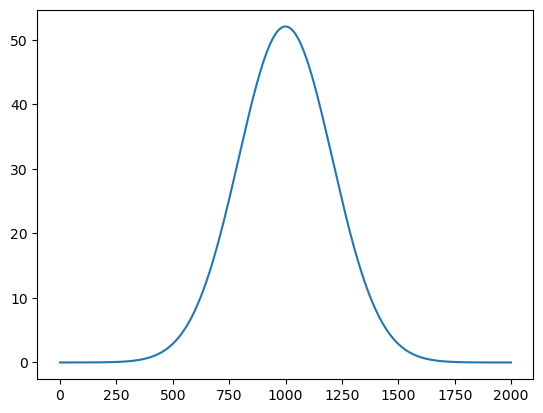

In [3]:
plt.plot(psf)

# Generate dataset

In [4]:
from Image_generation.image1D import SourceImage1D, add_guassian, normalise_img_int, randomize_img_int, CustomUnlabeledDataset

image_cls = SourceImage1D(dim_in, img_size=dim_in*pixel_size)

single_source, single_source_mirror,  separations = image_cls.generate_displaced_single_slit(42000, d_min=-0.3*unit, d_max=0.3*unit)

separations = torch.tensor(separations/unit)

tensor(0.2959, dtype=torch.float64)


2000

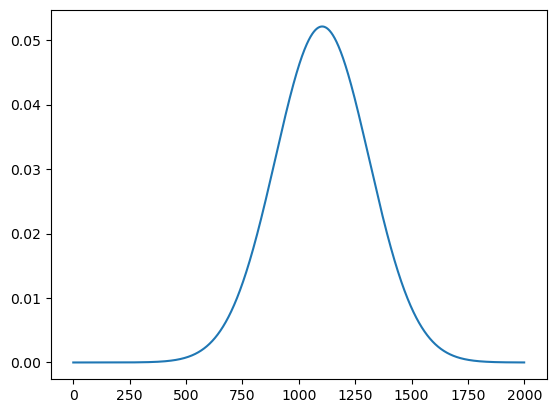

In [5]:
img_num = 18
test = propagate(single_source[img_num], psf)
#plt.plot(double_source[img_num])
plt.plot(test)
print(separations[img_num])
len(test)

# Pass Through PSF

In [6]:
single_slits = []
single_slits_mirror = []

for i in range(0, len(single_source)):
    single_image = propagate(single_source[i], psf)
    single_image_mirror = propagate(single_source_mirror[i], psf)
    single_slits.append(single_image)
    single_slits_mirror.append(single_image_mirror)

In [7]:
single_slits = torch.tensor(single_slits, dtype=torch.cfloat)
single_slits_mirror = torch.tensor(single_slits_mirror, dtype=torch.cfloat)

C:\Users\TF\AppData\Local\Temp\ipykernel_12248\1009298486.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  single_slits = torch.tensor(single_slits, dtype=torch.cfloat)


In [119]:
two_slits.size(1)

2

# Load Dataset for training

In [127]:
from torch.utils.data import DataLoader, random_split

# Normalise intensity
input_intensity = 10000
normed_single_slits = normalise_img_int(single_slits, pixel_size, input_intensity)
normed_single_slits_mirror = normalise_img_int(single_slits_mirror, pixel_size, input_intensity)

# Randomize intensity
# input_intensity = 1e6*torch.rand(single_slits.size(0))+10
# single_slits = randomize_img_int(single_slits, pixel_size, input_intensity.unsqueeze(1))
# single_slits_mirror = normalise_img_int(single_slits_mirror, pixel_size, input_intensity.unsqueeze(1))

two_slits = torch.stack((normed_single_slits, normed_single_slits_mirror), dim=1)

images = two_slits
labels = separations

dataset = CustomUnlabeledDataset(images, labels)
dataset = DataLoader(dataset, shuffle=True)

train_set, val_set = random_split(dataset.dataset, [30000, 12000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=30, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=30, shuffle=False)

In [23]:
two_slits[:,0,:].size()

torch.Size([30000, 2000])

# Define model

In [82]:
from LinearNN import Linear

network_dimensions = [2000, 2000, 2000, 2000, 2000]
pixel_size = 1e-6
wavelengths_1 = [700e-9, 705e-9, 690e-9]
wavelengths_2 =  [702e-9, 708e-9, 696e-9]
layer_distance = 0.03
samples_per_pixel = 1
backend = "riemann"
device='cuda'

# Define the model

diffml_models_1 = [diffml.DONN(network_dimensions, pixel_size, wavelength, layer_distance, 
                           samples_per_pixel, backend, 
                           phase_modulation_init='constant' , amplitude_modulation_init = 'constant') for wavelength in wavelengths_1]
diffml_models_2 = [diffml.DONN(network_dimensions, pixel_size, wavelength, layer_distance, 
                           samples_per_pixel, backend, 
                           phase_modulation_init='constant' , amplitude_modulation_init = 'constant') for wavelength in wavelengths_2]
diffml_models_1 = [model.to(device) for model in diffml_models_1]
diffml_models_2 = [model.to(device) for model in diffml_models_2]


In [108]:
# Define the linear model
import torch.nn as nn

class Linear_mix(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim

        self.layer_stack = nn.Sequential(
            *[nn.Linear(input_dim, 100),
              nn.Softplus(),
              nn.Linear(100, 100),
              nn.ReLU(),
              nn.Linear(100, 100),
              nn.ReLU(),
              nn.Linear(100, 10),
              nn.ReLU(),
              nn.Linear(10, 1),
              ]
        )

    def forward(self, x):
        x = self.layer_stack(x)
        return x


# Digital_NN_dim = [2000,2000,1]
digital_NN = Linear_mix(2000)

# Define Training Function

In [126]:
import torch.nn as nn

# output normalisation
Normalisation = 1e-3

def calc_output(diffml_models_1, diffml_models_2, digital_model, data, noise=True):
    '''
    
    Calculate the outputs of the model during training and validation.
    '''
    data = data.squeeze() 
    data.to(device)
    
    
    for model in diffml_models_1:
        model.to(device)
    for model in diffml_models_2:
        model.to(device)
    # pass through diffNN
    # slit 1 introducing rand pahse
    output_field_1 = [model(data[:,0,:]*torch.exp(1j * torch.rand(2000, device=device))) for model in diffml_models_1]
    # slit 2
    output_field_2 = [model(data[:,1,:]*torch.exp(1j * torch.rand(2000, device=device))) for model in diffml_models_2]
    
    output_field = torch.zeros_like(output_field_1[0])
    for output in output_field_1:
        output_field += output
    for output in output_field_2:
        output_field += output    
           
    output_intensity = torch.abs(output_field)**2*pixel_size/6
    total_output_intensity = torch.sum(output_intensity, dim=1)
    
    digital_model.to(device)
    # for testing only digital NN 
#     in_field = data[:,0,:] + data[:,1,:]
#     output_intensity = torch.abs(in_field)**2*pixel_size/4
#     total_output_intensity = torch.sum(output_intensity, dim=1)
    
    # Apply Poisson noise to output of diffNN using reparametrization trick
    if noise:
        poisson_int = torch.poisson(output_intensity)
        noise = (poisson_int - output_intensity).detach().clone()
        output_intensity += noise

    # Pass through Digital NN
    output = digital_model(output_intensity).squeeze()
    output /= Normalisation

    return output, total_output_intensity, output_intensity

# Define training function

def train(diffml_models_1, diffml_models_2, digital_NN, noise, device, train_loader, optimizer_diff, optimizer_digital, epoch, tot_loss: list):
    
    for model in diffml_models_1:
        model.train()
    for model in diffml_models_2:
        model.train() 
   
    digital_NN.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        for optimizer in optimizer_diff:
            optimizer.zero_grad()
            
        optimizer_digital.zero_grad()
        
        output, total_output_intensity, _ = calc_output(diffml_models_1, diffml_models_2, digital_NN, data, noise)
        
        loss = nn.MSELoss()(output, target)
        loss.backward()
        
        for optimizer in optimizer_diff:
            optimizer.step()
            
        optimizer_digital.step()
        
        if batch_idx % 100 == 0:
                print(f"Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} ({100.0 * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                tot_loss.append(loss.item())

# Print output to check for normalisation and scaling

In [111]:
for i, (data, target) in enumerate(val_loader):
    for model in diffml_models_1:
        model.eval()
    for model in diffml_models_2:
        model.eval() 
    digital_NN.eval()
    data, target = data.to(device), target.to(device)
    output, output_intensity,_ = calc_output(diffml_models_1, diffml_models_2, digital_NN, data, noise=False)
    
    if i == 0:
        print('        label, ouput, output intensity:')
        print(torch.stack((target, output, output_intensity), dim=1))
        break

        label, ouput, output intensity:
tensor([[-1.7437e-01, -9.5652e-04,  4.7903e+03],
        [-9.1474e-02, -9.5652e-04,  4.9396e+03],
        [ 2.0010e-01, -9.5652e-04,  4.7281e+03],
        [ 2.7156e-02, -9.5652e-04,  4.9948e+03],
        [ 9.4333e-02, -9.5652e-04,  4.9359e+03],
        [ 2.4012e-01, -9.5652e-04,  4.6189e+03],
        [-9.8621e-02, -9.5652e-04,  4.9320e+03],
        [ 1.4150e-01, -9.5652e-04,  4.8621e+03],
        [-2.8729e-01, -9.5652e-04,  4.4785e+03],
        [-7.2894e-02, -9.5652e-04,  4.9626e+03],
        [ 8.4328e-02, -9.5652e-04,  4.9501e+03],
        [ 5.5742e-02, -9.5652e-04,  4.9781e+03],
        [-2.8014e-01, -9.5652e-04,  4.4968e+03],
        [-2.3726e-01, -9.5652e-04,  4.6272e+03],
        [-7.0035e-02, -9.5652e-04,  4.9655e+03],
        [-1.9295e-01, -9.5652e-04,  4.7496e+03],
        [-2.0010e-02, -9.5652e-04,  4.9967e+03],
        [-1.8295e-01, -9.5652e-04,  4.7703e+03],
        [-1.9152e-01, -9.5652e-04,  4.7496e+03],
        [ 1.1863e-01, -9.5652

# Train

In [129]:
import torch.optim as optim

noise = True
device = 'cuda'

lr_diff = 0.01
lr_digital = 0.01
#torch.autograd.set_detect_anomaly(True)

optimizer_diff = []
for model in diffml_models_1:
    optimizer = optim.Adam(model.parameters(), lr=lr_diff)
    optimizer_diff.append(optimizer)
for model in diffml_models_2:
    optimizer = optim.Adam(model.parameters(), lr=lr_diff)
    optimizer_diff.append(optimizer)    
    

optimizer2 = optim.Adam(digital_NN.parameters(), lr=lr_digital)

num_epochs = 3
tot_loss = []
for epoch in range(1, num_epochs + 1):
    train(diffml_models_1, diffml_models_2, digital_NN, noise, device, train_loader, optimizer_diff, optimizer2, epoch, tot_loss)
    #validate(model, device, val_loader)

print("Training complete!")

Train Epoch: 1 [0/30000 (0%)]	Loss: 0.027088
Train Epoch: 1 [3000/30000 (10%)]	Loss: 0.025965
Train Epoch: 1 [6000/30000 (20%)]	Loss: 0.059444
Train Epoch: 1 [9000/30000 (30%)]	Loss: 0.045361
Train Epoch: 1 [12000/30000 (40%)]	Loss: 0.035911
Train Epoch: 1 [15000/30000 (50%)]	Loss: 0.040364
Train Epoch: 1 [18000/30000 (60%)]	Loss: 0.040641
Train Epoch: 1 [21000/30000 (70%)]	Loss: 0.025978
Train Epoch: 1 [24000/30000 (80%)]	Loss: 0.023679
Train Epoch: 1 [27000/30000 (90%)]	Loss: 0.024350
Train Epoch: 2 [0/30000 (0%)]	Loss: 0.034008
Train Epoch: 2 [3000/30000 (10%)]	Loss: 0.043028
Train Epoch: 2 [6000/30000 (20%)]	Loss: 0.136569
Train Epoch: 2 [9000/30000 (30%)]	Loss: 0.029273
Train Epoch: 2 [12000/30000 (40%)]	Loss: 0.037437
Train Epoch: 2 [15000/30000 (50%)]	Loss: 0.048430
Train Epoch: 2 [18000/30000 (60%)]	Loss: 0.029831
Train Epoch: 2 [21000/30000 (70%)]	Loss: 0.033843
Train Epoch: 2 [24000/30000 (80%)]	Loss: 0.195444
Train Epoch: 2 [27000/30000 (90%)]	Loss: 0.086121
Train Epoch: 3 [

In [ ]:
plt.plot(tot_loss)
plt.yscale('log')
plt.xlabel('batches')
plt.ylabel('log loss')

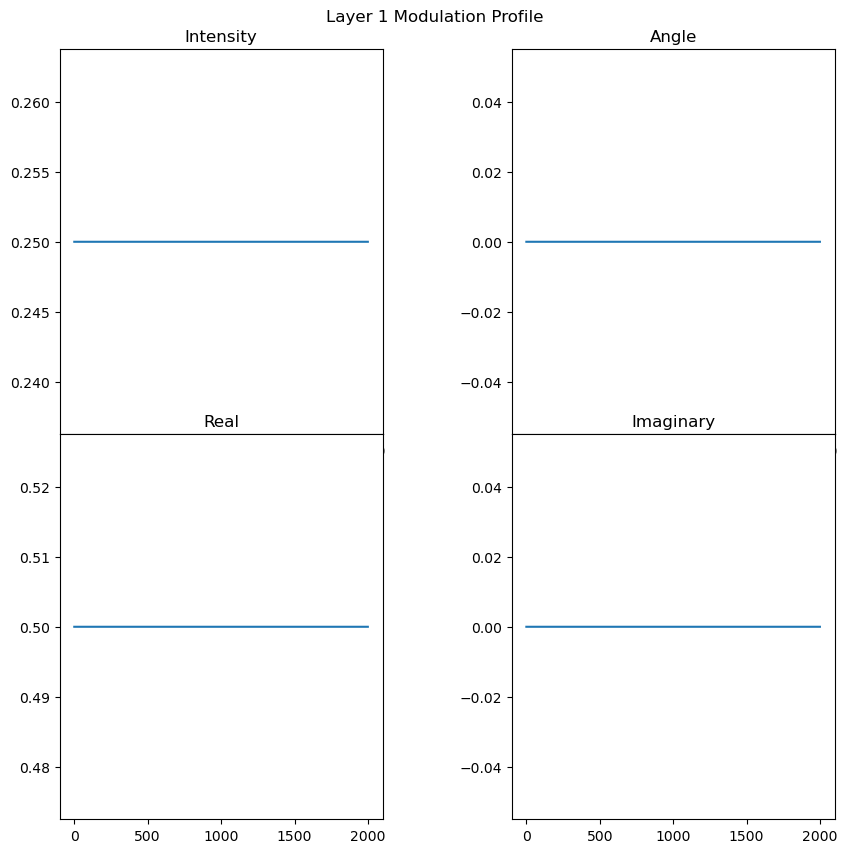

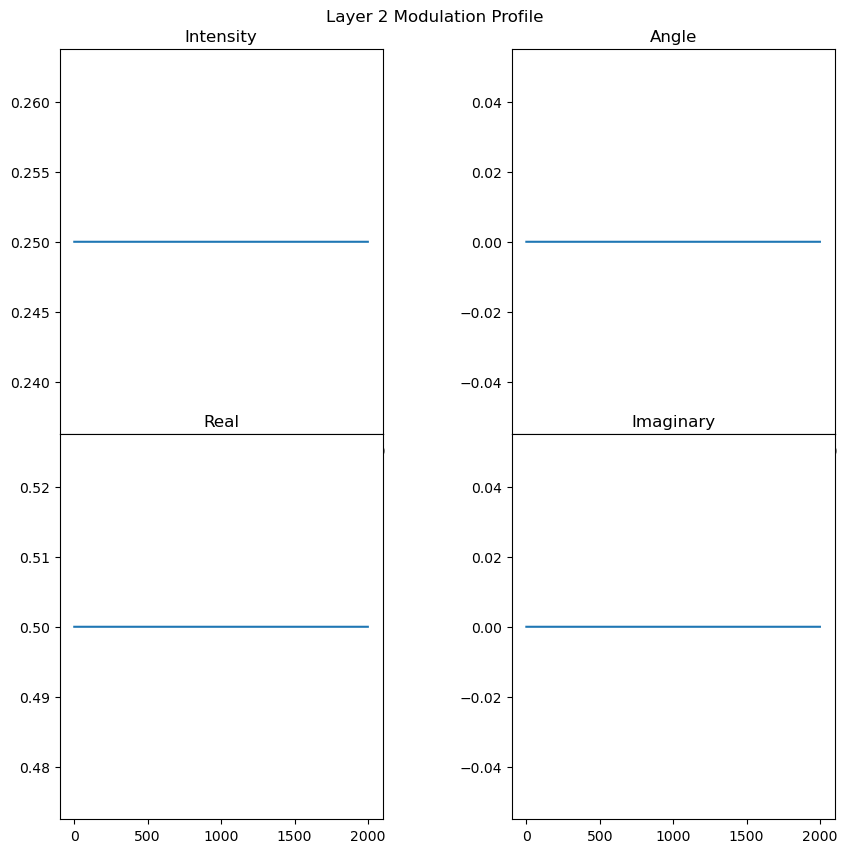

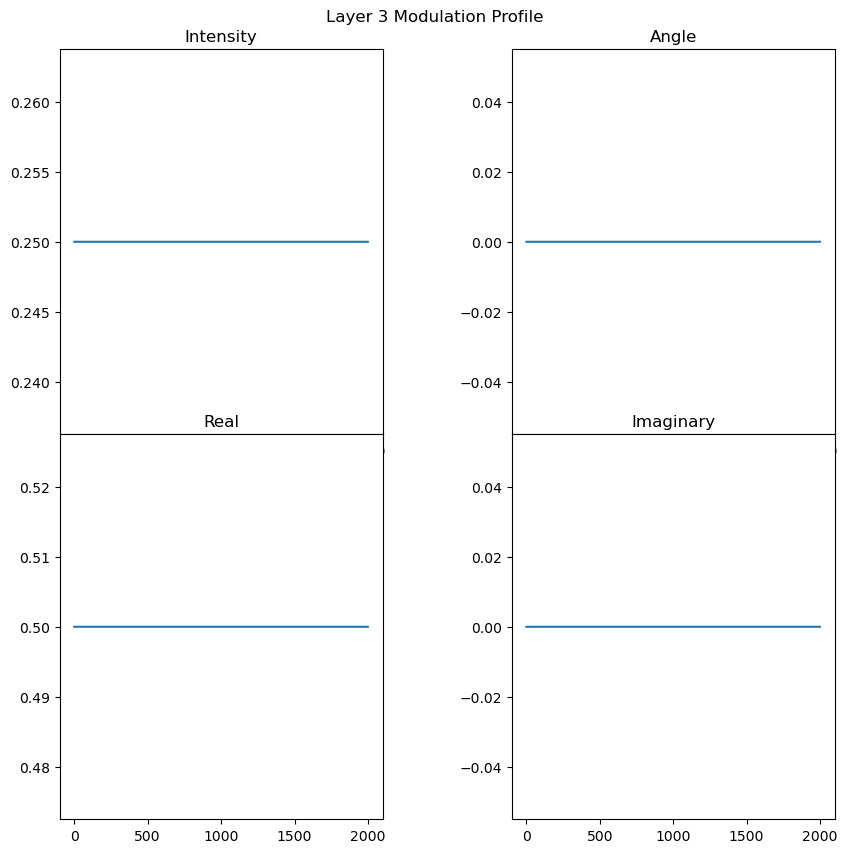

C:\Users\TF\AppData\Local\Temp\ipykernel_12248\371337997.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test = torch.tensor(test, dtype=torch.cfloat, device='cuda')


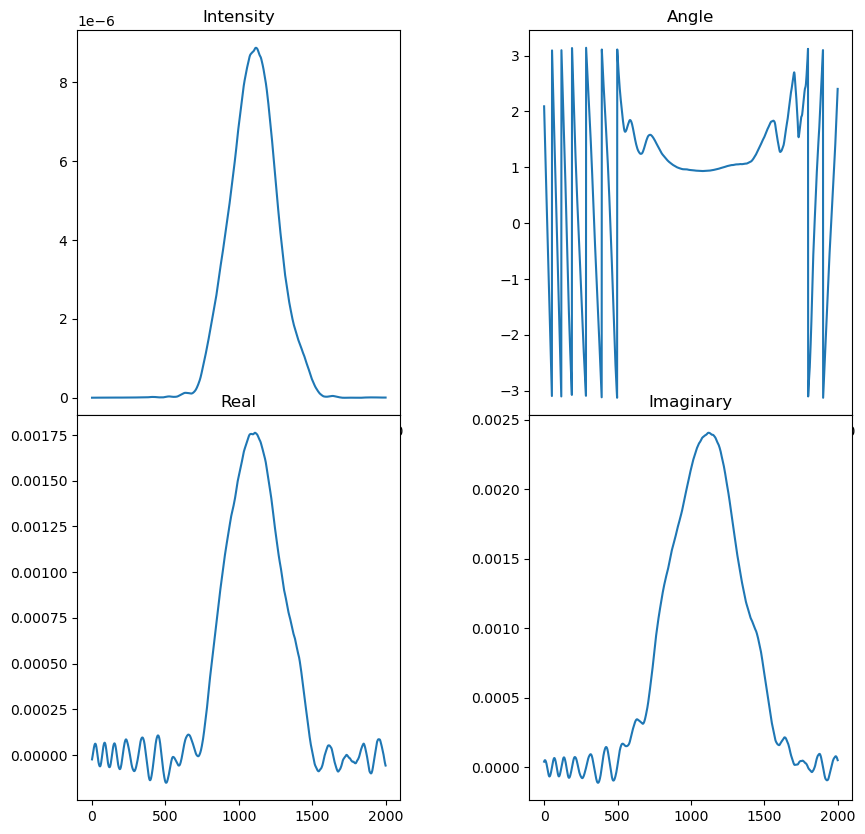

In [128]:
model_idx = 0
diffml.plot_system_layers(diffml_models_2[model_idx])

diffml_models_2[model_idx].eval()
diffml_models_2[model_idx].to('cuda')

test = torch.tensor(test, dtype=torch.cfloat, device='cuda')

output_test = diffml_models_2[model_idx](test* torch.rand(2000, device = 'cuda'))
plot_field(output_test)

In [104]:
import matplotlib.pyplot as plt

cumu_out = []
cumu_sep = []
cumu_int = [] 

output_image = []
device = 'cpu'
for i, (data, target) in enumerate(val_loader):
    for model in diffml_models_1:
        model.eval()
    for model in diffml_models_2:
        model.eval() 
   
    digital_NN.eval()
    data, target = data.to('cpu'), target.to('cpu')
    output, output_intensity, image = calc_output(diffml_models_1, diffml_models_2, digital_NN, data, noise=False)
    cumu_out.append(output.detach().numpy())
    cumu_sep.append(target.numpy())
    cumu_int.append(output_intensity.detach().numpy())
    output_image.append(image.detach().numpy())
    
cumu_out = np.array(cumu_out).flatten()
cumu_sep = np.array(cumu_sep).flatten()
cumu_int = np.array(cumu_int).flatten()
#bias = cumu_out-cumu_sep
output_stat = [cumu_sep, cumu_out]

Text(0, 0.5, 'predicted separation/unit')

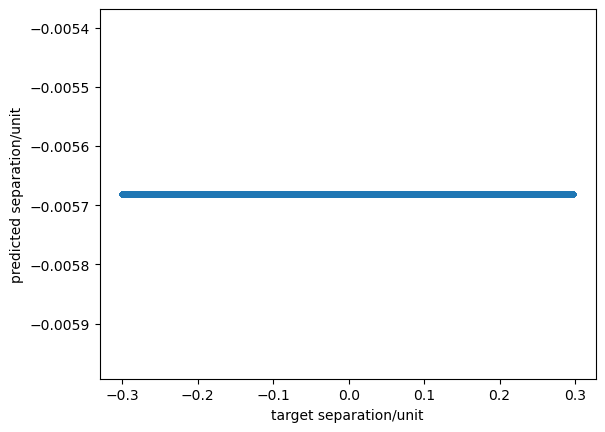

In [101]:
plt.scatter(cumu_sep, cumu_out, marker = '.')
plt.xlabel('target separation/unit')
plt.ylabel('predicted separation/unit')

In [102]:
import statistics
from collections import defaultdict

def process_output_stat(output_stat):
    cumu_sep, cumu_out = output_stat

    # Combine and sort the data by cumu_sep
    combined = sorted(zip(cumu_sep, cumu_out), key=lambda x: x[0])

    # Group cumu_out values by cumu_sep and calculate statistics
    grouped = defaultdict(list)
    for sep, out in combined:
        grouped[sep].append(float(out))

    # Prepare the result list
    result_3_by_n = [[], [], [], [], []]
    for sep in sorted(grouped):
        out_values = grouped[sep]
        number_repeat = len(out_values)
        mean_out = statistics.mean(out_values)
        variance_out = statistics.variance(out_values) if len(out_values) > 1 else 0.0
        reciprocal_variance = 1.0 / variance_out if variance_out != 0 else 0
        result_3_by_n[0].append(sep)
        result_3_by_n[1].append(mean_out)
        result_3_by_n[2].append(variance_out)
        result_3_by_n[3].append(reciprocal_variance)
        result_3_by_n[4].append(number_repeat)
    return result_3_by_n

result_stat = process_output_stat(output_stat)

24147.405607055778

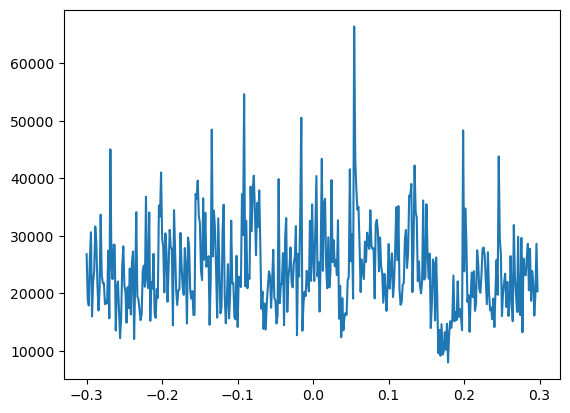

In [79]:
plt.plot(result_stat[0], result_stat[3])
statistics.mean(result_stat[3])

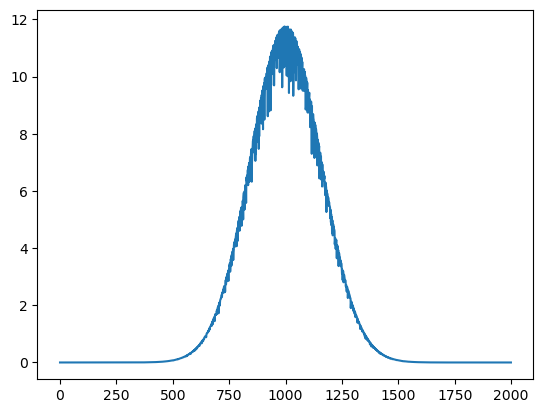

In [105]:
plt.plot(output_image[1][6])


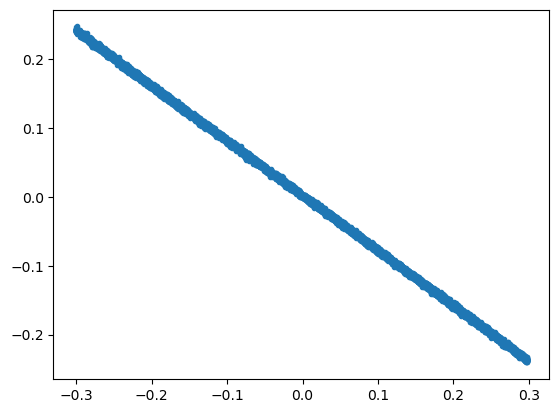

In [414]:
plt.scatter(cumu_sep, cumu_out-cumu_sep, marker = '.')

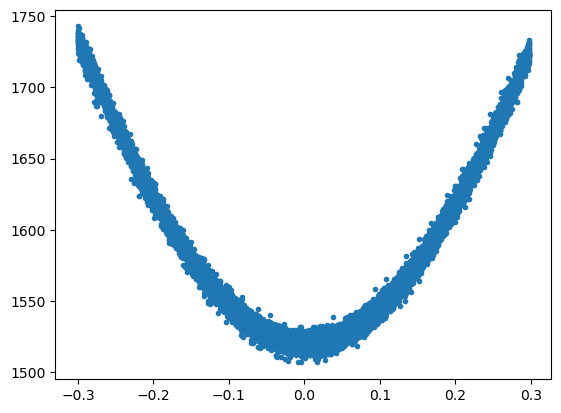

In [412]:
plt.scatter(cumu_sep, cumu_int, marker = '.')

In [123]:
photon_num = [1000, 10000, 100, 5000, 2000, 8000, 1000, 3000, 6000, 5000]
FI = [10724, 88726, 1272, 52694, 16515, 29818, 4950, 14111, 27802, 24147]
pn_digital = [1000, 2000, 3000, 100, 5000, 1e4]
FI_digital = [1045, 1827, 2494, 369, 3484, 3888]

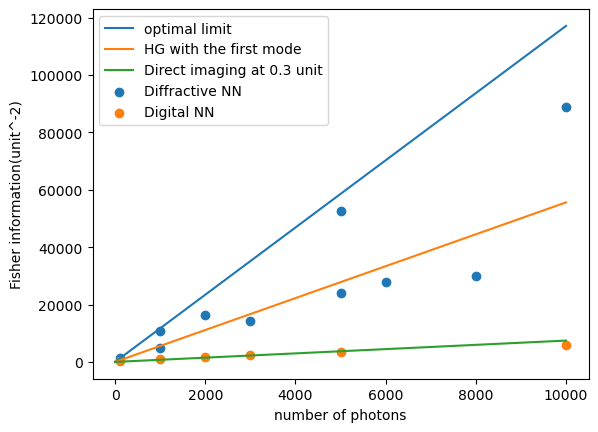

In [130]:
x = np.linspace(0,1e4, num=1000)
plt.xlabel('number of photons')
plt.ylabel('Fisher information(unit^-2)')
plt.plot(x, 11.71*x, label='optimal limit')
plt.plot(x, 5.56*x, label='HG with the first mode')
plt.plot(x, 0.744*x, label='Direct imaging at 0.3 unit')
plt.scatter(photon_num, FI, label='Diffractive NN')
plt.scatter(pn_digital, FI_digital, label='Digital NN')
plt.legend()